In [1]:
# Cell 1: Install dependencies
%pip install --quiet gymnasium[box2d] stable-baselines3[extra] matplotlib seaborn numpy pandas torch swig box2d-py



  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [29 lines of output]
      Using setuptools (version 80.3.1).
      /root/venv/lib/python3.9/site-packages/setuptools/_distutils/dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      /root/venv/lib/python3.9/site-packages/setuptools/dist.py:761: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: zlib/libpng License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ********************************************************************************
      
      !!
        s

In [2]:
# Cell 1: Imports
import time
import gc
import random
from collections import deque

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal

from stable_baselines3 import PPO, SAC, DDPG, A2C
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, ProgressBarCallback, CallbackList


2025-05-14 06:00:42.490281: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 06:00:42.524218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 06:00:42.524315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 06:00:42.525200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 06:00:42.530545: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Cell 2: Custom Environment: Simple1D-v0
class Simple1DEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self):
        super(Simple1DEnv, self).__init__()
        self.size = 11
        self.max_steps = 20
        self.action_space = spaces.Discrete(2)  # 0=left, 1=right
        self.observation_space = spaces.Box(low=0, high=self.size-1, shape=(1,), dtype=np.int32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.pos = 0
        self.steps = 0
        return np.array([self.pos], dtype=np.int32), {}

    def step(self, action):
        self.pos = np.clip(self.pos + (1 if action == 1 else -1), 0, self.size-1)
        self.steps += 1

        reward = -0.1
        terminated = (self.pos == self.size - 1)
        truncated = (self.steps >= self.max_steps)
        if terminated:
            reward = 20.0

        return np.array([self.pos], dtype=np.int32), reward, terminated, truncated, {}

    def render(self):
        line = ["_"] * self.size
        line[self.pos] = "A"
        print("|" + "".join(line) + "|")

    def close(self):
        pass

# Register the Simple1DEnv
try:
    register(
        id="Simple1D-v0",
        entry_point=Simple1DEnv,
        max_episode_steps=20
    )
except Exception:
    pass


In [4]:
# Cell 3: EpisodeCountCallback
class EpisodeCountCallback(BaseCallback):
    def __init__(self, max_episodes: int, verbose: int = 1):
        super().__init__(verbose)
        self.max_episodes = max_episodes
        self.episode_count = 0

    def _on_step(self) -> bool:
        infos = self.locals.get('infos', [])
        for info in infos:
            if info.get('episode') is not None:
                self.episode_count += 1
                if self.episode_count >= self.max_episodes:
                    if self.verbose:
                        print(f"Reached {self.max_episodes} episodes, stopping training.")
                    return False
        return True


In [5]:
# Cell 4: REINFORCE Agent (Discrete/Continuous)
class REINFORCEAgent(nn.Module):
    def __init__(self, obs_dim, act_dim, continuous=False, gamma=0.99, lr=1e-3):
        super().__init__()
        self.gamma = gamma
        # feature extractor
        if obs_dim == 1:
            self.net = nn.Sequential(nn.Linear(obs_dim, 16), nn.ReLU())
            hidden = 16
        else:
            self.net = nn.Sequential(
                nn.Linear(obs_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
            )
            hidden = 64
        self.continuous = continuous
        if continuous:
            self.mu = nn.Linear(hidden, act_dim)
            self.log_std = nn.Parameter(torch.zeros(act_dim))
        else:
            self.logits = nn.Linear(hidden, act_dim)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, obs):
        h = self.net(obs)
        if self.continuous:
            return self.mu(h), torch.exp(self.log_std)
        return self.logits(h)

    def get_dist(self, obs):
        out = self.forward(obs)
        if self.continuous:
            mu, std = out
            return Normal(mu, std)
        return Categorical(logits=out)

    def sample_episode(self, env):
        obs, _ = env.reset()
        traj = {"logps": [], "rews": [], "dones": []}
        done = False
        while not done:
            obs_t = torch.as_tensor(obs, dtype=torch.float32)
            dist = self.get_dist(obs_t)
            a = dist.sample()
            lp = dist.log_prob(a).sum() if self.continuous else dist.log_prob(a)
            action = a.detach().cpu().numpy() if self.continuous else int(a.item())
            obs, r, term, trunc, _ = env.step(action)
            done = term or trunc
            traj["logps"].append(lp)
            traj["rews"].append(r)
            traj["dones"].append(done)
        return traj

    def compute_returns(self, rews, dones):
        returns = []
        G = 0.0
        for r, d in zip(reversed(rews), reversed(dones)):
            G = r + (0.0 if d else self.gamma * G)
            returns.insert(0, G)
        return torch.tensor(returns, dtype=torch.float32)

    def update(self, env):
        traj = self.sample_episode(env)
        returns = self.compute_returns(traj["rews"], traj["dones"])
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        logps = torch.stack(traj["logps"])
        loss = -torch.sum(logps * returns)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        total_reward = sum(traj["rews"])
        total_penalty = sum(-r for r in traj["rews"] if r < 0)
        return total_reward, total_penalty


In [6]:
# Cell 5: ReplayBuffer and TD3 Agent
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def add(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        S, A, R, S2, D = map(np.stack, zip(*batch))
        return S, A, R.reshape(-1, 1), S2, D.reshape(-1, 1)

    def __len__(self):
        return len(self.buffer)

class TD3Agent:
    def __init__(
        self,
        obs_dim,
        act_dim,
        act_range,
        lr=1e-3,
        gamma=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_delay=2,
    ):
        self.gamma, self.tau, self.ar = gamma, tau, act_range
        self.pn, self.nc = policy_noise * act_range, noise_clip * act_range
        self.pd, self.uc = policy_delay, 0

        # actor + target
        self.actor = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, act_dim),
            nn.Tanh(),
        )
        self.actor_t = nn.Sequential(*[l for l in self.actor])
        self.actor_t.load_state_dict(self.actor.state_dict())
        self.a_opt = optim.Adam(self.actor.parameters(), lr=lr)

        # critics + targets
        def make_critic():
            return nn.Sequential(
                nn.Linear(obs_dim + act_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
            )
        self.c1, self.c2 = make_critic(), make_critic()
        self.c1_t, self.c2_t = make_critic(), make_critic()
        self.c1_t.load_state_dict(self.c1.state_dict())
        self.c2_t.load_state_dict(self.c2.state_dict())
        self.c_opt = optim.Adam(
            list(self.c1.parameters()) + list(self.c2.parameters()), lr=lr
        )

    def get_action(self, obs, noise_scale=0.1):
        with torch.no_grad():
            a = self.actor(torch.FloatTensor(obs).unsqueeze(0)).squeeze(0)
        a = a + torch.randn_like(a) * noise_scale * self.ar
        return a.clamp(-self.ar, self.ar).numpy()

    def update(self, buf: ReplayBuffer, batch_size: int):
        S, A, R, S2, D = buf.sample(batch_size)
        S, A, S2 = map(torch.FloatTensor, (S, A, S2))
        R, D = torch.FloatTensor(R), torch.FloatTensor(D)

        with torch.no_grad():
            noise = (torch.randn_like(A) * self.pn).clamp(-self.nc, self.nc)
            A2 = (self.actor_t(S2) + noise).clamp(-self.ar, self.ar)
            Q1_t = self.c1_t(torch.cat([S2, A2], 1))
            Q2_t = self.c2_t(torch.cat([S2, A2], 1))
            Qt = R + self.gamma * (1 - D) * torch.min(Q1_t, Q2_t)

        Q1 = self.c1(torch.cat([S, A], 1))
        Q2 = self.c2(torch.cat([S, A], 1))
        c_loss = nn.MSELoss()(Q1, Qt) + nn.MSELoss()(Q2, Qt)

        self.c_opt.zero_grad()
        c_loss.backward()
        self.c_opt.step()

        self.uc += 1
        if self.uc % self.pd == 0:
            a_loss = -self.c1(torch.cat([S, self.actor(S)], 1)).mean()
            self.a_opt.zero_grad()
            a_loss.backward()
            self.a_opt.step()
            # soft updates
            for p, pt in zip(self.actor.parameters(), self.actor_t.parameters()):
                pt.data.mul_(1 - self.tau)
                pt.data.add_(p.data * self.tau)
            for net, nt in [(self.c1, self.c1_t), (self.c2, self.c2_t)]:
                for p, pt in zip(net.parameters(), nt.parameters()):
                    pt.data.mul_(1 - self.tau)
                    pt.data.add_(p.data * self.tau)


In [7]:
# Cell 6: Experiment Runner
def run_experiments(env_id, algos, total_timesteps, max_episodes, n_seeds, render=False):
    episode_rewards = {a: [] for a in algos}
    episode_penalties = {a: [] for a in algos}
    eval_returns = {a: [] for a in algos}

    for algo in algos:
        print(f"\n>> Algorithm: {algo}")
        for seed in range(1, n_seeds + 1):
            print(f"Seed: {seed}")

            train_env = Monitor(gym.make(env_id))
            train_env.reset(seed=seed)
            obs_dim = train_env.observation_space.shape[0]
            is_cont = isinstance(train_env.action_space, spaces.Box)
            act_dim = (train_env.action_space.shape[0] if is_cont
                       else train_env.action_space.n)
            act_range = float(train_env.action_space.high[0]) if is_cont else None

            rewards_hist, penalties_hist = [], []

            if algo == "REINFORCE":
                agent = REINFORCEAgent(obs_dim, act_dim, continuous=is_cont)
                for _ in range(max_episodes):
                    r, p = agent.update(train_env)
                    rewards_hist.append(r)
                    penalties_hist.append(p)
                agent_eval = agent
                train_env.close()

            elif algo in ["PPO", "SAC", "DDPG", "A2C"]:
                # Stable-Baselines3
                if algo == "PPO":
                    model = PPO("MlpPolicy", train_env, seed=seed, verbose=0)
                elif algo == "SAC":
                    model = SAC("MlpPolicy", train_env, seed=seed, verbose=0,
                                buffer_size=total_timesteps)
                elif algo == "DDPG":
                    noise = NormalActionNoise(
                        mean=np.zeros(act_dim), sigma=0.1 * np.ones(act_dim))
                    model = DDPG("MlpPolicy", train_env,
                                 action_noise=noise, seed=seed, verbose=0)
                else:  # A2C
                    model = A2C("MlpPolicy", train_env, seed=seed, verbose=0)

                cbs = CallbackList([EpisodeCountCallback(max_episodes),
                                    ProgressBarCallback()])
                model.learn(total_timesteps=total_timesteps,
                            callback=cbs,
                            reset_num_timesteps=False)

                rews = list(train_env.get_episode_rewards()[:max_episodes])
                lengths = list(train_env.get_episode_lengths()[:max_episodes])
                pens = [l * 0.1 for l in lengths]

                rewards_hist, penalties_hist = rews, pens
                agent_eval = model
                train_env.close()

            else:  # TD3
                agent = TD3Agent(obs_dim, act_dim, act_range)
                buf = ReplayBuffer(total_timesteps)
                for _ in range(max_episodes):
                    obs, _ = train_env.reset()
                    done = False
                    ep_rs = []
                    while not done and len(buf) < total_timesteps:
                        a = agent.get_action(obs)
                        obs2, r, term, trunc, _ = train_env.step(a)
                        buf.add(obs, a, r, obs2, float(term or trunc))
                        obs = obs2
                        ep_rs.append(r)
                        if len(buf) >= 100:
                            agent.update(buf, 100)
                        done = term or trunc
                    rewards_hist.append(sum(ep_rs))
                    penalties_hist.append(sum(-r for r in ep_rs if r < 0))
                agent_eval = agent
                train_env.close()

            episode_rewards[algo].append(rewards_hist)
            episode_penalties[algo].append(penalties_hist)

            # evaluation
            ev = Monitor(gym.make(env_id))
            ev.reset(seed=100 + seed)
            scores = []
            for _ in range(10):
                obs, _ = ev.reset()
                done = False
                G = 0.0
                while not done:
                    if algo in ["PPO", "SAC", "DDPG", "A2C"]:
                        a, _ = agent_eval.predict(obs, deterministic=True)
                    elif algo == "REINFORCE":
                        obs_t = torch.as_tensor(obs, dtype=torch.float32)
                        dist = agent_eval.get_dist(obs_t)
                        if isinstance(dist, Categorical):
                            a = dist.probs.argmax().item()
                        else:
                            a = dist.mean.detach().cpu().numpy()
                    else:
                        a = agent_eval.get_action(obs, noise_scale=0)
                    obs, r, term, trunc, _ = ev.step(a)
                    if render:
                        ev.render()
                    G += r
                    done = term or trunc
                scores.append(G)
            eval_returns[algo].append(np.mean(scores))

            ev.close()
            gc.collect()
            print(f"Seed {seed} eval return: {eval_returns[algo][-1]:.1f}")

    return episode_rewards, episode_penalties, eval_returns


In [8]:
# Cell 7: Plotting Helpers
def plot_learning_curves(all_results):
    for eid, (rews, pens, rets) in all_results.items():
        plt.figure(figsize=(10, 6))
        plt.title(f"Learning Curves ({eid})")
        plt.xlabel("Episode"); plt.ylabel("Total Reward")
        for algo, runs in rews.items():
            minl = min(len(r) for r in runs)
            arr = np.array([r[:minl] for r in runs])
            m, s = arr.mean(axis=0), arr.std(axis=0)
            ws = max(1, minl // 20)
            if ws > 1:
                m = np.convolve(m, np.ones(ws)/ws, mode="valid")
                s = np.convolve(s, np.ones(ws)/ws, mode="valid")
            xs = np.arange(len(m))
            plt.plot(xs, m, label=algo)
            plt.fill_between(xs, m - s, m + s, alpha=0.2)
        plt.legend(); plt.tight_layout(); plt.show()

def plot_final_performance(all_results):
    for eid, (_, _, rets) in all_results.items():
        plt.figure(figsize=(8, 5))
        plt.title(f"Final Performance ({eid})")
        data = [{"Algorithm": algo, "Return": v}
                for algo, vals in rets.items() for v in vals]
        df = pd.DataFrame(data)
        sns.barplot(x="Algorithm", y="Return", data=df,
                    errorbar="sd", capsize=0.1)
        plt.ylabel("Mean Evaluation Return")
        plt.tight_layout(); plt.show()


=== Simple1D-v0 Experiments ===

>> Algorithm: PPO
Seed: 1


/root/venv/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Reached 1000 episodes, stopping training.

Seed 1 eval return: 19.1
Seed: 2


Reached 1000 episodes, stopping training.

Seed 2 eval return: 19.1
Seed: 3


Reached 1000 episodes, stopping training.

Seed 3 eval return: 19.1

>> Algorithm: REINFORCE
Seed: 1
Seed 1 eval return: 19.1
Seed: 2
Seed 2 eval return: 19.1
Seed: 3
Seed 3 eval return: 19.1


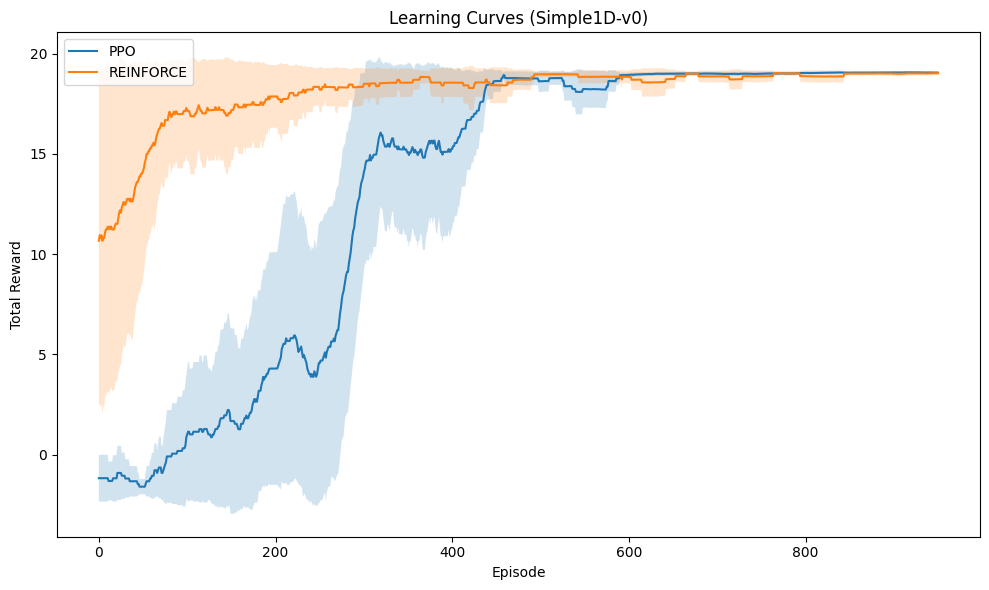

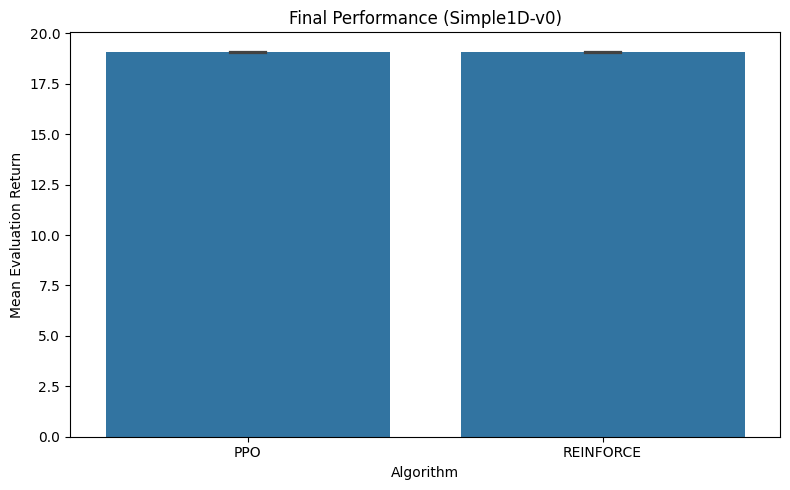

In [9]:
# Cell 8: Simple1D-v0 experiment
env_id    = "Simple1D-v0"
algos     = ["PPO", "REINFORCE"]
timesteps = 50_000
max_eps   = 1000
n_seeds   = 3
render    = False

print(f"=== {env_id} Experiments ===")
rews_s1d, pens_s1d, rets_s1d = run_experiments(
    env_id, algos, timesteps, max_eps, n_seeds, render=render)
results = {env_id: (rews_s1d, pens_s1d, rets_s1d)}

plot_learning_curves(results)
plot_final_performance(results)


In [10]:
# Cell 9: Summary for Simple1D-v0
summary = []
for algo in rews_s1d:
    for seed_idx, (r_list, p_list) in enumerate(zip(rews_s1d[algo], pens_s1d[algo]), start=1):
        summary.append({
            "Environment":       env_id,
            "Algorithm":         algo,
            "Seed":              seed_idx,
            "Episodes":          len(r_list),
            "Mean Reward":       np.mean(r_list),
            "Max Reward":        np.max(r_list),
            "Final Eval Return": rets_s1d[algo][seed_idx-1],
            "Penalties":         sum(p_list)
        })

summary_df = pd.DataFrame(summary)
print(f"\n=== Summary for {env_id} ===")
print(summary_df.to_string(index=False))



=== Summary for Simple1D-v0 ===
Environment Algorithm  Seed  Episodes  Mean Reward  Max Reward  Final Eval Return  Penalties
Simple1D-v0       PPO     1      1000      13.6382        19.1               19.1     1416.7
Simple1D-v0       PPO     2      1000      12.4787        19.1               19.1     1450.6
Simple1D-v0       PPO     3      1000      13.0024        19.1               19.1     1409.3
Simple1D-v0 REINFORCE     1      1000      17.6982        19.1               19.1     1081.8
Simple1D-v0 REINFORCE     2      1000      18.9271        19.1               19.1     1012.9
Simple1D-v0 REINFORCE     3      1000      17.1074        19.1               19.1     1232.6


/root/venv/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

=== LunarLander-v3 Experiments ===

>> Algorithm: PPO
Seed: 1


Reached 3000 episodes, stopping training.

Seed 1 eval return: 220.6
Seed: 2


Reached 3000 episodes, stopping training.

Seed 2 eval return: 140.7
Seed: 3


Reached 3000 episodes, stopping training.

Seed 3 eval return: 159.9

>> Algorithm: A2C
Seed: 1


Reached 3000 episodes, stopping training.

Seed 1 eval return: -16.4
Seed: 2


Reached 3000 episodes, stopping training.

Seed 2 eval return: 22.0
Seed: 3


Reached 3000 episodes, stopping training.

Seed 3 eval return: 82.4

>> Algorithm: REINFORCE
Seed: 1
Seed 1 eval return: 168.4
Seed: 2
Seed 2 eval return: 20.9
Seed: 3
Seed 3 eval return: -8.4


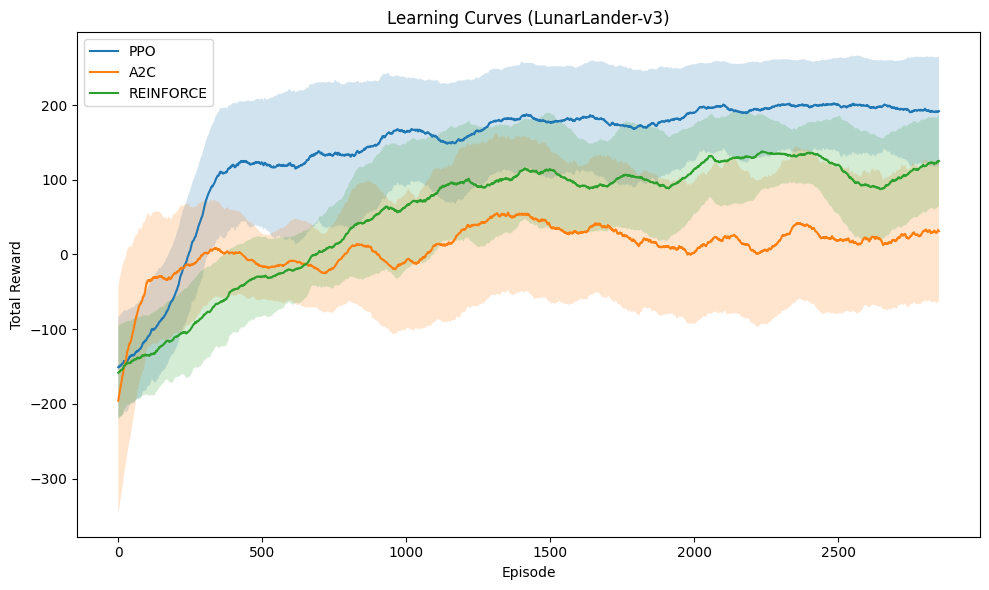

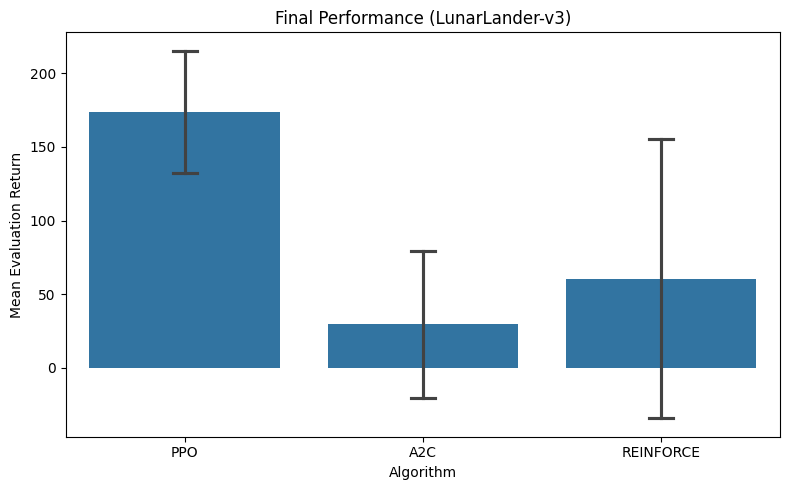

In [11]:
# Cell 10: LunarLander-v3 experiment
env_id    = "LunarLander-v3"
algos     = ["PPO", "A2C", "REINFORCE"]
timesteps = 2_000_000
max_eps   = 3000
n_seeds   = 3
render    = False

print(f"=== {env_id} Experiments ===")
rews_ll, pens_ll, rets_ll = run_experiments(
    env_id, algos, timesteps, max_eps, n_seeds, render=render)
results = {env_id: (rews_ll, pens_ll, rets_ll)}

plot_learning_curves(results)
plot_final_performance(results)


In [12]:
# Cell 11: Summary for LunarLander-v3
summary = []
for algo in rews_ll:
    for seed_idx, (r_list, p_list) in enumerate(zip(rews_ll[algo], pens_ll[algo]), start=1):
        summary.append({
            "Environment":       env_id,
            "Algorithm":         algo,
            "Seed":              seed_idx,
            "Episodes":          len(r_list),
            "Mean Reward":       np.mean(r_list),
            "Max Reward":        np.max(r_list),
            "Final Eval Return": rets_ll[algo][seed_idx-1],
            "Penalties":         sum(p_list)
        })

summary_df = pd.DataFrame(summary)
print(f"\n=== Summary for {env_id} ===")
print(summary_df.to_string(index=False))



=== Summary for LunarLander-v3 ===
   Environment Algorithm  Seed  Episodes  Mean Reward  Max Reward  Final Eval Return    Penalties
LunarLander-v3       PPO     1      3000   170.225318  314.019647         220.587825 1.028317e+05
LunarLander-v3       PPO     2      3000   128.334731  317.887948         140.704857 1.015967e+05
LunarLander-v3       PPO     3      3000   113.543093  278.631542         159.895848 1.721399e+05
LunarLander-v3       A2C     1      3000    16.000363  301.603779         -16.370928 1.202737e+05
LunarLander-v3       A2C     2      3000    -3.290267  309.921256          22.033873 1.144684e+05
LunarLander-v3       A2C     3      3000    -4.037468  313.521292          82.360439 1.184910e+05
LunarLander-v3 REINFORCE     1      3000    58.894869  299.033468         168.439766 1.317550e+06
LunarLander-v3 REINFORCE     2      3000    49.146202  302.540604          20.928445 1.087424e+06
LunarLander-v3 REINFORCE     3      3000    48.714985  298.984877          -8.4177

/root/venv/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

=== LunarLanderContinuous-v3 Experiments ===

>> Algorithm: DDPG
Seed: 1


Reached 2500 episodes, stopping training.

Seed 1 eval return: 189.9
Seed: 2


Reached 2500 episodes, stopping training.

Seed 2 eval return: 262.3
Seed: 3


Reached 2500 episodes, stopping training.

Seed 3 eval return: 253.1

>> Algorithm: REINFORCE
Seed: 1
Seed 1 eval return: 157.7
Seed: 2
Seed 2 eval return: 177.7
Seed: 3
Seed 3 eval return: 226.0

>> Algorithm: TD3
Seed: 1
Seed 1 eval return: 292.6
Seed: 2
Seed 2 eval return: 250.2
Seed: 3
Seed 3 eval return: 299.4


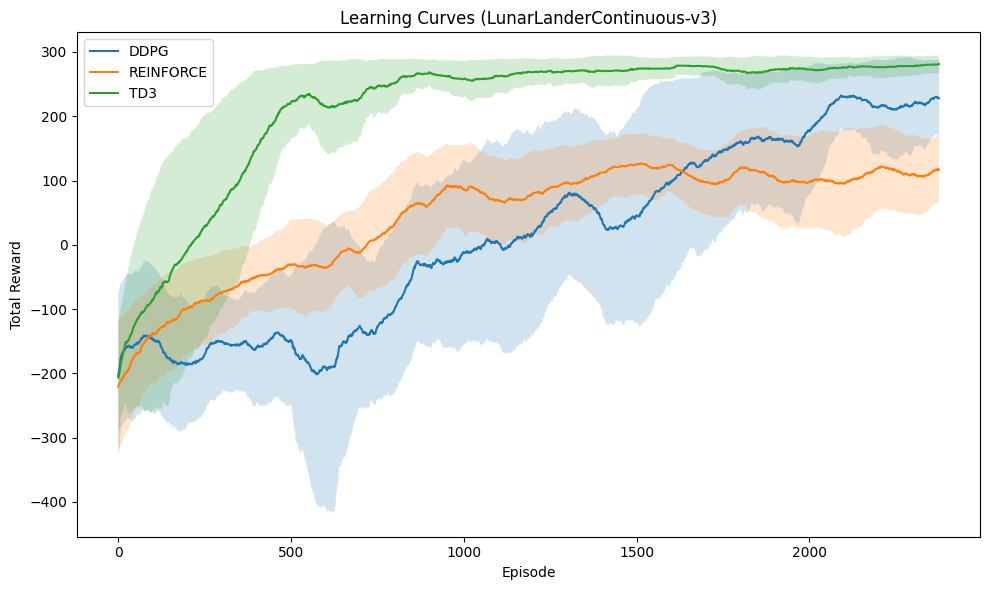

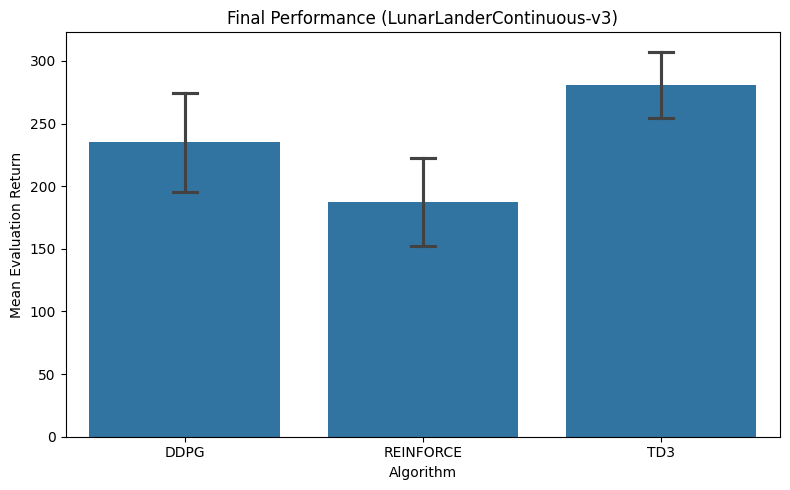

In [13]:
# Cell 12: LunarLanderContinuous-v3 experiment
env_id    = "LunarLanderContinuous-v3"
algos     = ["DDPG", "REINFORCE", "TD3"]
timesteps = 2_000_000
max_eps   = 2500
n_seeds   = 3
render    = False

print(f"=== {env_id} Experiments ===")
rews_llc, pens_llc, rets_llc = run_experiments(
    env_id, algos, timesteps, max_eps, n_seeds, render=render)
results = {env_id: (rews_llc, pens_llc, rets_llc)}

plot_learning_curves(results)
plot_final_performance(results)


In [14]:
# Cell 13: Summary for LunarLanderContinuous-v3
summary = []
for algo in rews_llc:
    for seed_idx, (r_list, p_list) in enumerate(zip(rews_llc[algo], pens_llc[algo]), start=1):
        summary.append({
            "Environment":       env_id,
            "Algorithm":         algo,
            "Seed":              seed_idx,
            "Episodes":          len(r_list),
            "Mean Reward":       np.mean(r_list),
            "Max Reward":        np.max(r_list),
            "Final Eval Return": rets_llc[algo][seed_idx-1],
            "Penalties":         sum(p_list)
        })

summary_df = pd.DataFrame(summary)
print(f"\n=== Summary for {env_id} ===")
print(summary_df.to_string(index=False))



=== Summary for LunarLanderContinuous-v3 ===
             Environment Algorithm  Seed  Episodes  Mean Reward  Max Reward  Final Eval Return     Penalties
LunarLanderContinuous-v3      DDPG     1      2500   -60.653684  323.727282         189.896384  74603.000000
LunarLanderContinuous-v3      DDPG     2      2500    23.373096  321.908929         262.325925  71310.500000
LunarLanderContinuous-v3      DDPG     3      2500    70.114109  317.810896         253.063015  74030.200000
LunarLanderContinuous-v3 REINFORCE     1      2500    24.317557  285.677661         157.706609 990046.358083
LunarLanderContinuous-v3 REINFORCE     2      2500    67.048956  298.527683         177.659976 935718.519171
LunarLanderContinuous-v3 REINFORCE     3      2500    22.726000  286.174066         226.042398 982625.574113
LunarLanderContinuous-v3       TD3     1      2500   244.030278  329.947687         292.610585 220714.193186
LunarLanderContinuous-v3       TD3     2      2500   194.010086  323.737945       

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=308febca-8f13-4285-877f-cd5594b992f2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>